In [14]:
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parse_results import *
from utils.utils import *
from db_utils.utils import *
from db_utils.query_storage import *
import networkx as nx
from cardinality_estimation.algs import *
import numpy as np
from cardinality_estimation.losses import *
from cardinality_estimation.join_loss import JoinLoss, get_join_cost_sql
from sql_rep.utils import nodes_to_sql, path_to_join_order
#from cvxopt import matrix, solvers
#import cvxopt
import cvxpy as cp
import time
# FIXME: separate jupyter utils files especially for plotting utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def qerr(true, est):
    qerrs = []
    for k,y in true.items():
        yhat = est[k]
        qerrs.append(max( y / yhat, yhat / y))
    return sum(qerrs) / len(qerrs)

def eval_alg(sql, y, yhat, join_graph):
    print("qerr: ", qerr(y, yhat))
    est_costs, opt_costs, est_plans, opt_plans, est_sqls, opt_sqls = \
                env.compute_join_order_loss([sql], [join_graph],
                        [y], [yhat], None, False, num_processes=1, postgres=True, pool=None)
    print("jerr: {}".format(est_costs[0]-opt_costs[0]))
    plot_explain_join_order(est_plans[0], y, yhat, None, "Plan based on Estimates")
    plt.show()

    plot_explain_join_order(opt_plans[0], y, y, None, "Plan based on true values")
    plt.show()
    return opt_costs[0]

def plot_flow_path(edges, subsetg, solx, final_node, source_node):
    source_node = tuple("s")
    cur_node = final_node
    edge_dict = {}
    edge_widths = {}
    for i, e in enumerate(edges):
        edge_dict[e] = i
        edge_widths[e] = solx[i]

    all_edges = []
    best_path_nodes = []
    while True:
        out_edges = subsetg.out_edges(cur_node)
        min_cost_edge = None
        min_cost = -100000000000
    
        for edge in out_edges:
            idx = edge_dict[edge]
            wt = solx[idx]
            if wt > min_cost:
                min_cost_edge = edge
                min_cost = wt
        all_edges.append(min_cost_edge)
        best_path_nodes.append(cur_node)
        cur_node = min_cost_edge[1]
        all_edges.append(min_cost_edge)
        if cur_node == source_node:
            best_path_nodes.append(cur_node) 
            break

    print("going to draw flow path")
    draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths)
    

In [16]:
QUERY_DIR = "./our_dataset/queries/"
query = "1a/1a10.pkl"

#QUERY_DIR = "./debug_sqls/"
#query = "0.pkl"
#query = "2.pkl"

qfn = QUERY_DIR + query
postgres = Postgres()
true_alg = TrueCardinalities()


# for join loss computations
env = JoinLoss("cm1", "pari", "", "localhost", 5432, "imdb")


In [17]:
qrep = load_sql_rep(qfn)
join_graph = qrep["join_graph"]
subset_graph = qrep["subset_graph"]
sql = qrep["sql"]
print(sql)

SELECT COUNT(*) FROM title as t,
kind_type as kt,
movie_info as mi1,
info_type as it1,
movie_info as mi2,
info_type as it2,
cast_info as ci,
role_type as rt,
name as n
WHERE
t.id = ci.movie_id
AND t.id = mi1.movie_id
AND t.id = mi2.movie_id
AND mi1.movie_id = mi2.movie_id
AND mi1.info_type_id = it1.id
AND mi2.info_type_id = it2.id
AND it1.id = '3'
AND it2.id = '2'
AND t.kind_id = kt.id
AND ci.person_id = n.id
AND ci.role_id = rt.id
AND mi1.info IN ('Adventure','Crime','Documentary','Family','Short')
AND mi2.info IN ('Black and White','Color')
AND kt.kind IN ('tv series','video game')
AND rt.role IN ('miscellaneous crew','writer')
AND n.gender IN ('f','m')
AND t.production_year <= 1970
AND 1950 < t.production_year



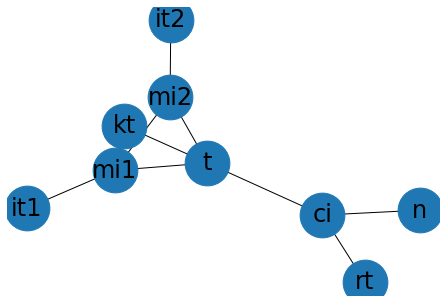

In [18]:
nx.draw(join_graph, pos=nx.spring_layout(join_graph), with_labels=True, node_size=2000, font_size=24)

In [19]:
y = true_alg.test([qrep])
y_pg = postgres.test([qrep])

random_alg = Random()
true_random = TrueRandom()
y_rand = random_alg.test([qrep])
y_true_rand = true_random.test([qrep])
sql = fix_query(sql)

opt_cost = eval_alg(sql, y[0], y_pg[0], join_graph)

qerr:  5.609780907567885
compute postgres join error took:  0.03232693672180176
jerr: 1411002.72


ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

In [904]:
def dont_change_subset(k,v):
    ret = None
    #if "t" in k and "mi1" in k:
    if "ci" in k:
        ret = v
    else:
        ret = v + random.randint(-1000000,1000000)
    if ret <= 0:
        ret = 1
    return ret

def change_subset(k,v):
    ret = None
    # if "n" in k or "ci" in k:
    if "kt" in k and "t" in k and len(k) == 2:
       # ret = v -= random.randint(-100000,100000)
        ret = 10000
    #if "n" in k :
       # ret = random.randint(-100000,100000)
    #elif "rt" in k and "ci" in k and len(k) == 2:
        #ret = v * 1
    elif "rt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and "rt" in k and len(k) == 4:
        ret = 108 * 1000
    else:
        ret = v
        #ret = v + random.randint(-100,100)
    if ret <= 0:
        ret = 1
    return ret

def small_change(k,v):
    v += random.randint(-10000,10000)
    if v <= 0:
        v = 1
    return v
        
test_ests = {}
num_changed = 0
#for k,v in y[0].items():
for k,v in y_pg[0].items():
    test_ests[k] = change_subset(k,v)
    if test_ests[k] != v:
        num_changed += 1
        
print("total: {}, num changed: {}".format(len(y[0]), num_changed))
eval_alg(sql, y[0], test_ests)

total: 17, num changed: 4


TypeError: eval_alg() missing 1 required positional argument: 'join_graph'

In [20]:
subsetg = qrep["subset_graph"]
add_single_node_edges(subsetg)
final_node = [n for n,d in subsetg.in_degree() if d==0][0]
source_node = tuple("s")
draw_graph(subsetg)
compute_costs(subsetg)

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

<class 'networkx.classes.ordered.OrderedDiGraph'>
[('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'rt', 't'), ('ci', 'kt', 't'), ('kt', 't'), ('t',), ('s',)]


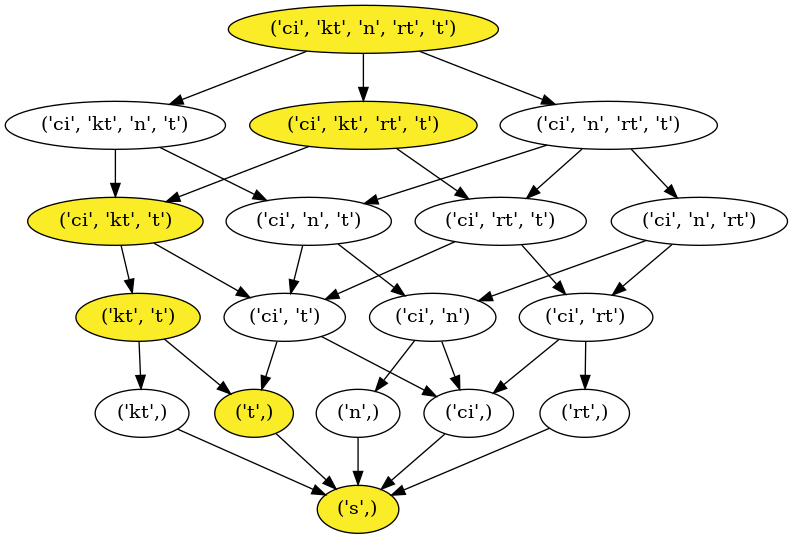

In [11]:
print(type(subsetg))
#print(subsetg.nodes())
path = nx.shortest_path(subsetg, final_node, source_node, weight="cost")
print(path)
draw_graph(subsetg, highlight_nodes=path)

In [12]:
path = path[0:-1]
join_order = [tuple(sorted(x)) for x in path_to_join_order(path)]
join_order.reverse()
sql_to_exec = nodes_to_sql(join_order, join_graph)
print(join_order)
# TODO: figure out a way to cost these

[('t',), ('kt',), ('ci',), ('rt',), ('n',)]


In [13]:
cost_sql, est_cost, est_explain = get_join_cost_sql(sql_to_exec, y[0], join_graph, 0, "ubuntu", "", "localhost", 5432, "imdb")
jerr = est_cost - opt_cost
print("jerr: ", jerr)

jerr:  33802.43000000017


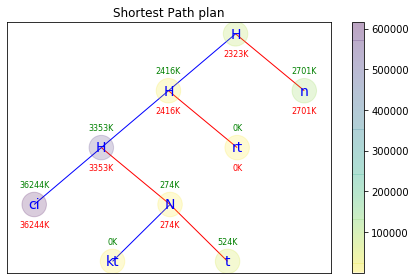

In [909]:
plot_explain_join_order(est_explain, y[0], y[0], None, "Shortest Path plan")
plt.show()

In [14]:
edges, c, A, b, G, h = construct_lp(subsetg)

In [15]:
print(A.shape)
print("A rank: ", np.linalg.matrix_rank(A))
print(b)
nodes = list(subsetg.nodes())
nodes.sort()

(18, 31)
A rank:  17
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]


In [16]:
start = time.time()
n = len(edges)
x = cp.Variable(n)
constraints = [A @ x == b, G @ x <= 0]
prob = cp.Problem(cp.Minimize(c.T@x), constraints)
prob.solve()
print(prob.value)
print(x.value)
print("linear program took: ", time.time()-start)

608.2534216242277
[3.07170055e-11 1.22871268e-09 9.99999999e-01 1.82808532e-11
 1.22399607e-09 5.69110235e-12 9.99999999e-01 5.69218212e-12
 5.73295349e-12 1.00000000e+00 4.59553651e-12 2.31344614e-12
 2.46456972e-12 2.87965860e-12 4.89992294e-12 6.87084590e-12
 7.56859168e-12 4.40031274e-12 8.41987087e-12 6.35269565e-12
 2.38191919e-12 5.83603391e-12 7.67844300e-12 2.04365125e-11
 8.39850043e-13 6.18843637e-11 6.27677962e-11 1.00000000e+00
 2.13559569e-12 2.19531720e-12 1.00000000e+00]
linear program took:  0.013049125671386719


('ci', 'kt', 'n', 'rt', 't') (('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'rt', 't'))
('ci', 'kt', 'rt', 't') (('ci', 'kt', 'rt', 't'), ('ci', 'kt', 't'))
('ci', 'kt', 't') (('ci', 'kt', 't'), ('kt', 't'))
('kt', 't') (('kt', 't'), ('t',))
('t',) (('t',), ('s',))


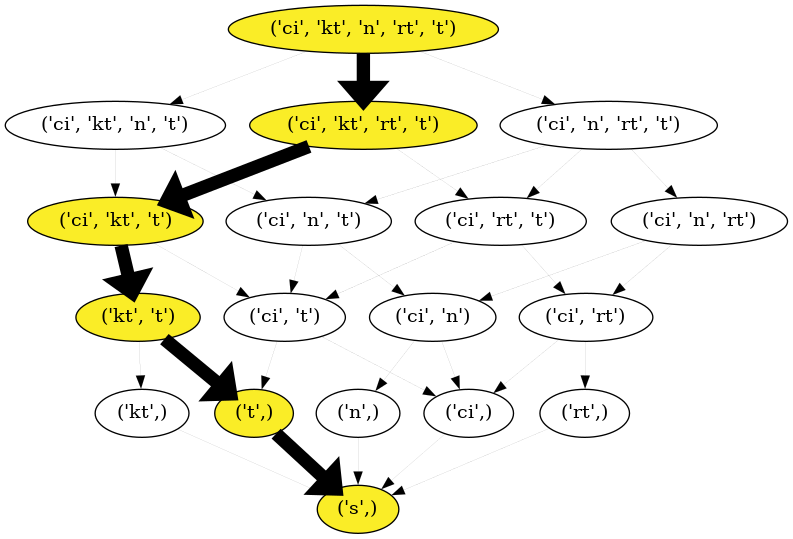

In [17]:
#cur_node = tuple("s")
solx = np.array(x.value)
source_node = tuple("s")
cur_node = final_node
edge_dict = {}
edge_widths = {}
for i, e in enumerate(edges):
    edge_dict[e] = i
    edge_widths[e] = solx[i]

all_edges = []
best_path_nodes = []
while True:
    # in_edges = subsetg.out_edges(cur_node)
    out_edges = subsetg.out_edges(cur_node)
    #print(out_edges)
    min_cost_edge = None
    min_cost = -100000000000
    
    for edge in out_edges:
        idx = edge_dict[edge]
        wt = solx[idx]
        if wt > min_cost:
            min_cost_edge = edge
            min_cost = wt
    print(cur_node, min_cost_edge)
    all_edges.append(min_cost_edge)
    best_path_nodes.append(cur_node)
    cur_node = min_cost_edge[1]
    all_edges.append(min_cost_edge)
    if cur_node == source_node:
        best_path_nodes.append(cur_node) 
        break

draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths)

In [18]:
edges, c, A, b, G, h = construct_lp(subsetg)

n = len(edges)
P = np.zeros((len(edges),len(edges)))
for i,c in enumerate(c):
    P[i,i] = c
    
q = np.zeros(len(edges))
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
                 [G @ x <= h,
                  A @ x == b])
prob.solve()
qsolx = np.array(x.value)
print(qsolx)

[3.65115697e-01 3.79538355e-01 4.03225103e-01 2.17236543e-01
 3.11970419e-01 6.75679358e-02 3.24041753e-01 7.91833492e-02
 8.36581956e-03 6.27646353e-01 4.25111395e-02 3.21045408e-03
 1.53789685e-02 2.36046416e-02 3.89836102e-02 8.66650943e-02
 9.15878383e-02 3.03426251e-02 1.23890405e-01 6.62094890e-02
 6.62268661e-05 4.26710742e-02 1.28100113e-01 2.56395069e-01
 3.96126905e-03 6.30612502e-04 6.30612502e-04 6.27015740e-01
 3.21045408e-03 6.62268661e-05 6.30977009e-01]


going to draw flow path


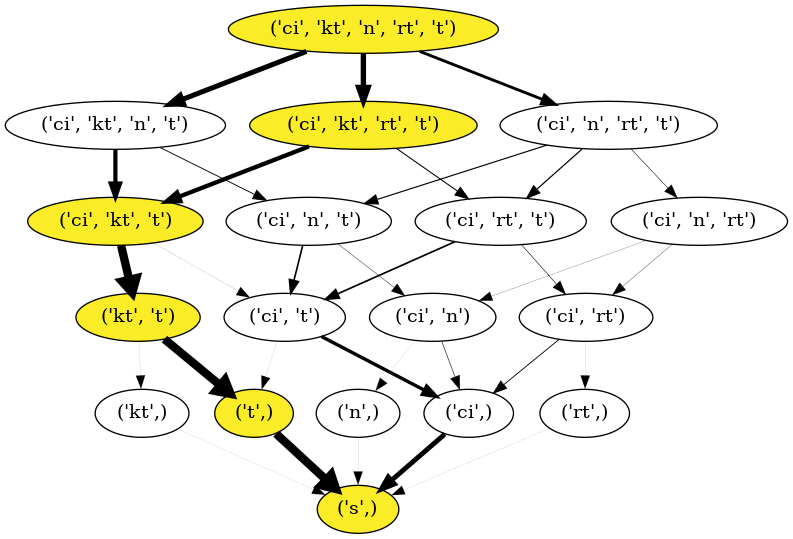

In [19]:
plot_flow_path(edges, subsetg, qsolx, final_node, source_node)

In [882]:
edge_order, G, Gv, Q = constructG(subsetg)

In [883]:
print(nodes[0])
print(G[0,:])
print(np.sum(G[0,:]))

('ci',)
[ 1.00002899e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.00220451e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.75882283e-01  0.00000000e+00 -4.01215467e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.00000000e+04  0.00000000e+00]
0.0


In [887]:
invG = np.linalg.inv(G)
v = invG @ Gv
flows = Q @ v
print(flows.shape)
print(qsolx.shape)
#for i, flow in enumerate(flows):
    #print(flow, qsolx[i])
sidxs = np.argsort(flows)
sol_idxs = np.argsort(qsolx)

(31,)
(31,)
[ 0 25 29 30 28 20 26  8 24 11 22  7 18  5 23 16 21 15 17  6 13  4  2  1
 12 19 27  9 10 14  3] [29 20 25 26  8 24 28 11 22  7 18  5 23 16 21 15 17  6 13  4  2  1 12 19
 27  9 30 10 14  3  0]


going to draw flow path


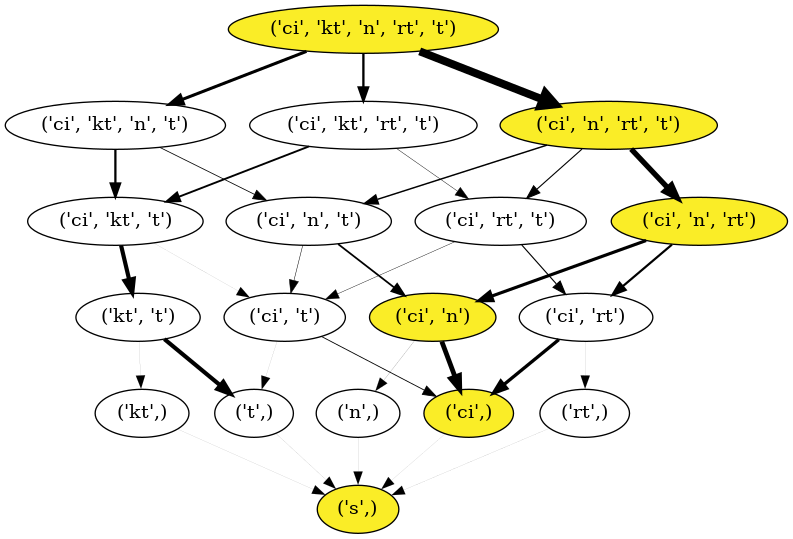

In [885]:
plot_flow_path(edges, subsetg, flows, final_node, source_node)